In [1]:
# Imports
import numpy as np
import math
import matplotlib.pyplot as plt
import sys
np.random.seed(5)

### Q.1 (70pts) Define functions

In [2]:
# One hot encode the labels
def one_hot_encode(y):
    targets = np.array(np.unique(y)).reshape(-1)
    enc = np.eye(len(targets))[y]
    #print(enc)
    return enc

# Get the loss of for the training example
def cross_entropy(Y, Yhat):
    m= Y.shape[1]
#     eps=1e-15
#     Yhat = np.clip(Yhat, eps, 1-eps)
#     loss = np.multiply(np.log(Yhat),Y) + np.multiply((1.-Y), np.log(1. - Yhat))
#     loss = np.sum(loss)
#     cost = -1./m * np.sum(loss)
#     cost = np.squeeze(cost)
    cost = (-1/m) * (np.sum(np.multiply(Y, np.log(Yhat)) + np.multiply(1 - Y, np.log(1 - Yhat))))
    return cost

# Applying Sigmoid Activation function to the hidden layer outputs used while forward propagation
# Purpose of this method is to do squishing on the linear function
def sigmoid(z):
    sigmoid = 1.0/(1.0 + np.exp(-z))
    return sigmoid

# Applying Sigmoid Activation function to the hidden layer outputs used while backward propagation to get gradients
# Purpose of this method is to do undo the squishing on the linear function
def sigmoid_prime(z):
    inv = (np.exp(-z))/(np.power((1+np.exp(-z)),2))
    return inv

def relu(z):
    return np.maximum(z,0)
    
def relu_prime(z):
    return np.int64(z>0)

# Softmax activation function to get the probablity of the classes
def softmax(z):
    softMax = (np.exp(z) / np.sum(np.exp(z),axis=0))
    softMax = np.matrix(np.argmax(softMax,axis=0)).T
    return softMax

def zero_pad(X, pad):
    ## Pads the height and width and breadth only by 'pad' columns using constant value, 4 dimensional padding
    padded_array = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0,0)), 'constant', constant_values = (0,0))
    #print("Dimension after padding" + str(padded_array.shape))
    return padded_array

# Convolution of a slice
def convolute_slice(a_slice, W, b):
    conv = np.multiply(a_slice, W)
    z = np.sum(conv) + float(b)
    return z

# Calculate the coordinates of the slice
def get_slice_coordinates(stride, f, w, h):
    vert_start = h * stride
    vert_end = vert_start + f
    horiz_start = w * stride
    horiz_end = horiz_start + f
    return vert_start, vert_end, horiz_start, horiz_end

# Flatten the array
def flatten(A):
    (m, nH, nW, nC) = A.shape
    #print('Shape before flattening is----')
    #print(A.shape)
    A = A.reshape(m, nH * nW * nC)
    #print('Shape after flattening is----')
    #print(A.shape)
    return A

def plotCostHistory(cost_history, alpha, i):
     line = plt.plot(cost_history, label=alpha)
     plt.ylabel('Cost');
     plt.ylim( (0, 4) )
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations for different learning rates')
     plt.legend()

def convolute_forward(x, weight, b, pad, stride):
    # get dimensions from a and w
    (m, nh_prev, nw_prev, nc_prev) = x.shape
    (f, f, nc_prev, nc) = weight.shape
 
    # calc dimensions of output matrix
    nh = int((nh_prev - f + 2 * pad) / stride) + 1
    nw = int((nw_prev - f + 2 * pad) / stride) + 1
    
    z = np.zeros((m, nh, nw, nc))
    a = np.zeros((m, nh, nw, nc))

    a_pad = np.pad(x, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    # print(a_pad[0])
    # a_pad = np.pad(a, (pad, pad), 'constant', constant_values=0)

    for i in range(m):
        a_val = a_pad[i]
        for h in range(nh):
            for w in range(nw):
                for c in range(nc):

                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice = a_val[vert_start:vert_end, horiz_start:horiz_end, :]

                    # convolution
                    s = np.multiply(a_slice, weight[:,:,:,c]) + b[:,:,:,c]
                    z[i, h, w, c] = np.sum(s)
                    a[i, h, w, c] = relu(z[i, h, w, c])
    return a

def pool_forward(a, f, stride, pool_type):
    (m, nh_prev, nw_prev, nc_prev) = a.shape
    
    nh = int(1 + (nh_prev - f)/stride)
    nw = int(1 + (nw_prev - f)/stride)
    nc = nc_prev
    
    pool_m = np.zeros((m, nh, nw, nc))
    
    for i in range(m):
        for h in range(nh):
            for w in range(nw):
                for c in range(nc):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    pool_slice = a[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    if pool_type == 'avg':
                        pool_m[i, h, w, c] = np.mean(pool_slice)
                    else:
                        pool_m[i, h, w, c] = np.max(pool_slice)
    return pool_m
        
             
def convolute_backward(dZ, A_prev, W, b, hyper_params):
    # Get the input dimensions
    (m, nH_prev, nW_prev, nC_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape
    stride = hyper_params["stride"]
    pad = hyper_params["pad"]
    (m, nH, nW, nC) = dZ.shape
    dA_prev = np.zeros((m, nH_prev, nW_prev, nC_prev))                           
    dW = np.zeros((f, f, nC_prev, nC))
    db = np.zeros((1, 1, 1, n_C))
    A_pad_prev = zero_pad(A_prev, pad)
    dA_pad_prev = zero_pad(dA_prev, pad)
    
    for i in range(m):
        
        a_pad_prev = A_pad_prev[i,:,:,:]
        da_pad_prev = dA_pad_prev[i,:,:,:]
        
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):

                    # Find the coordinates of the current slice
                    vert_start, vert_end, horiz_start, horiz_end = get_slice_coordinates(stride, f, w, h)

                    # Extract the slice from input
                    a_slice = A_pad_prev[i, vert_start:vert_end, horiz_start:horiz_end, :]

                    da_pad_prev[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
    
        #dA_prev[i, :, :, :] = da_pad_prev[pad:-pad, pad:-pad, :]
    assert(dA_prev.shape == (m, nH_prev, nW_prev, nC_prev))
    return dA_prev, dW, db


# Backward pass for max pooling for a slice
def backprop_max_pooling(x):
    mask = x==np.max(x)
    return mask

# Backward pass for avg pooling for a slice
def backprop_avg_pooling(dz, slice_shape):
    (nH, nW) = slice_shape
    avg = dz/(nH * nW) # calculate avg
    a = np.ones((nH, nW)) * avg
    return a


def pool_backward(dA, A_prev, hyper_params, pooling_method):
    stride = hyper_params["stride"]
    f = hyper_params["f"]
    m, nH_prev, nW_prev, nC_prev = A_prev.shape
    m, nH, nW, nC = dA.shape
    dA_prev = np.zeros((m, nH_prev, nW_prev, nC_prev))
    
    for i in range(m):
        a_prev = A_prev[i,:,:,:]
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):
                    
                    # Find the coordinates of the current slice
                    vert_start, vert_end, horiz_start, horiz_end = get_slice_coordinates(stride, f, w, h)
                    #print("coordinate")
                    #print(vert_start, vert_end, horiz_start, horiz_end)
                    if(pooling_method == "max"):
                        a_slice_prev = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]                  
                        mask = backprop_max_pooling(a_slice_prev)
                        temp = mask * dA[i, h, w, c]
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += temp

                    elif(pooling_method == "avg"):
                        da = dA[i, h, w, c]
                        shape = (f,f)
                        #print('-----------dAprev shape---------')
                        #print(dA_prev.shape)
                        #print('-----------temp---------')
                        temp = backprop_avg_pooling(da, shape)
                        #print(temp.shape)
                        #print('--------------dAPrev----------')
                        #print(dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c])
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += temp
    
    assert(dA_prev.shape == A_prev.shape)
    return dA_prev


# Forward propagation to calculate yHat by applying activation function twice
def forward_propagate(cache, hyper_params, parameters):
    print('-----------------A0--------------')
    print(cache["A0"])
    # Layer 1 Convolution x, weight, b, pad, stride
    cache["Z1c"] = convolute_forward(cache["A0"], parameters["W1c"], parameters["b1c"], hyper_params["c1"]["pad"],hyper_params["c1"]["stride"]) # Convolution
    cache["A1c"] = relu(cache["Z1c"]) # Relu Activation
    print('-----------------Z1c--------------')
    print(cache["Z1c"])
    print('-----------------A1c--------------')
    print(cache["A1c"])
    
    # Layer 1 Pooling a, f, stride, pool_type
    cache["A1p"] = pool_forward(cache["A1c"], hyper_params["p1"]["f"],hyper_params["p1"]["stride"], "max") # Pooling
    print('-----------------A1p--------------')
    print(cache["A1p"])
    
    # Layer 2 Convolution 
    cache["Z2c"] = convolute_forward(cache["A1p"], parameters["W2c"], parameters["b2c"], hyper_params["c2"]["pad"],hyper_params["c2"]["stride"]) # Convolution
    cache["A2c"] = relu(cache["Z2c"]) # Relu Activation
    print('-----------------Z2c--------------')
    print(cache["Z2c"])
    print('-----------------A2c--------------')
    print(cache["A2c"])
    
    # Layer 2 Pooling 
    cache["A2p"] = pool_forward(cache["A2c"],hyper_params["p2"]["f"],hyper_params["p2"]["stride"], "avg") # Pooling
    print('-----------------A2p--------------')
    print(cache["A2p"])
    
    # Flatten the array
    cache["A3"] = flatten(cache["A2p"])
    print('-----------------A3--------------')
    print(cache["A3"])

    # Fully Connected Layer 4
    cache["Z4"] = np.dot(parameters["W4"], cache["A3"].transpose()) + parameters["b4"]
    cache["A4"] = relu(cache["Z4"]) # Relu Activation 
    print('-----------------Z4--------------')
    print(cache["Z4"])
    print('-----------------A4--------------')
    print(cache["A4"])
    
    # Fully Connected Layer 5
    cache["Z5"] = np.dot(parameters["W5"], cache["A4"]) + parameters["b5"]
    cache["A5"] = sigmoid(cache["Z5"]) # Sigmoid Activation 
    print('-----------------Z5--------------')
    print(cache["Z5"])
    print('-----------------A5--------------')
    print(cache["A5"])

    return cache


def backward_propagate(Y, cache, hyper_params, params):
    gradients = {}
    # Fully Connected Layer 5
    m = cache["A5"].shape[1]
    dZ5 = cache["A5"] - Y.transpose()
    dW5 = (1./m) * np.dot(dZ5, cache["A4"].transpose())
    db5 = (1./m) * np.ndarray.sum(dZ5, axis=1, keepdims=True)
    gradients["dW5"] = dW5
    gradients["db5"] = db5
    
    # Fully Connected Layer 4
    temp1 = np.dot( params["W5"].transpose(), dZ5 )
    temp2 = relu_prime(cache["Z4"])
    dZ4 = np.multiply(temp1 , temp2) # element wise product of same dimension matrices
    dW4 = (1./m) * np.dot(dZ4, cache["A3"])
    db4 = (1./m) * np.ndarray.sum(dZ4, axis =1, keepdims=True)
    gradients["dW4"] = dW4
    gradients["db4"] = db4
    
    # Un-Flaten the list
    (m, nH, nW, nC) = cache["A2p"].shape
    dP2 = cache["A3"].reshape(m, nH, nW, nC)
    
    dA2 = pool_backward(dP2, cache["A2c"], hyper_params["p2"], pooling_method="avg")
    dZ2 = relu_prime(dA2)
    #print("shape")
    #print(dZ2.shape)
    #print(cache["Z2c"].shape)
    dP1, dW2, db2 = convolute_backward(dZ2, cache["A1p"], params["W2c"], params["b2c"], hyper_params["c2"])
    gradients["dW2"] = dW2
    gradients["db2"] = db2
    
    
    dA1 = pool_backward(dP1, cache["A1c"], hyper_params["p1"], pooling_method="max")
    dZ1 = relu_prime(dA1)
    X, dW1, db1 = convolute_backward(dZ1, cache["A0"], params["W1c"], params["b1c"], hyper_params["c1"])
    gradients["dW1"] = dW1
    gradients["db1"] = db1
    
    return gradients


def gradient_descent_optimizer(X, Y, alpha, iters): 
    # Initialize params and hyper params
    cache = {}
    cache["A0"] = X
    params = initialize_parameters(input_channl=3, conv1_f=4, channl_1=8, conv2_f=4, channl_2=16, 
                              input_size=1296, fc1_size=108, fc2_size=6)
    hyper_params = initialize_hyper_params()
    
    old_cost = sys.maxsize
    new_cost = sys.maxsize
    cost_history = []

    for i in range(iters):
        # Call Forward propagation to calculate yHat
        cache = forward_propagate(cache, hyper_params, params)
        old_cost = new_cost
        Afinal = cache['A5']
        new_cost = cross_entropy(Y, Afinal.transpose())
        gradients = backward_propagate(Y, cache, hyper_params, params)
        
        # Update weights for convolution layer 1
        params["W1c"] = params["W1c"] - alpha * gradients['dW1']
        params["b1c"] = params["b1c"] - alpha * gradients['db1']
        
        # Update weights for convolution layer 2
        params["W2c"] = params["W2c"] - alpha * gradients['dW2']
        cache["b2c"] = params["b2c"] - alpha * gradients['db2']
        
        # Update weights for fully connected layer 1
        params["W4"] = params["W4"] - alpha * gradients['dW4']
        params["b4"] = params["b4"] - alpha * gradients['db4']
        
        # update weights for fully connected layer2
        params["W5"] = params["W5"] - alpha * gradients['dW5']
        params["b5"] = params["b5"] - alpha * gradients['db5']
        
        if(abs(old_cost - new_cost) < 0.00000000001):
            print("breaking" + str(old_cost) + str(new_cost))
            break;
        print ("cost : " + str(new_cost) + " Iteration: " + str(i))
        cost_history.append(new_cost)
    return cache, cost_history, new_cost, params

### Q.2 Load data

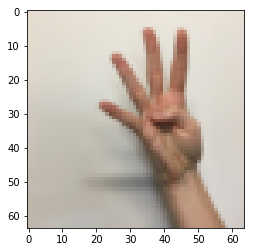

Digit in the image is 4


In [3]:
X_train = np.load('ex5_train_x.npy')
y_train = np.load('ex5_train_y.npy')
indx = 2
plt.imshow(X_train[indx])
plt.show()
print("Digit in the image is " + str(y_train[indx]))
# print(X_train)

# Normalize the data
X_train_norm = (X_train/255.0)
# print(X_train_norm)
y_train_encoded = one_hot_encode(y_train)
# X_train_padded = zero_pad(X_train, 2)

### Q.3 (10pts) Initialize parameters (Weights, bias for each layer)

In [4]:
def initialize_parameters(input_channl, conv1_f, channl_1, conv2_f, channl_2, 
                          input_size, fc1_size, fc2_size):
    params = {}
    # Convolution Layer 1 Params
    params["W1c"] =   0.01 * np.random.uniform(-1, 1, (conv1_f, conv1_f, input_channl, channl_1))
    params["b1c"] =  np.zeros((1,1,1, channl_1))
    
    # Convolution Layer 2 Params
    params["W2c"] =  0.01 * np.random.uniform(-1, 1, (conv2_f, conv2_f, channl_1, channl_2))
    params["b2c"] =  np.zeros((1,1,1,channl_2))
    
    # FC layer 4 params
    params["W4"] =  0.01 * np.random.uniform(-1, 1, (fc1_size, input_size))
    params["b4"] =  np.zeros((fc1_size, 1))
    
    # FC layer 5 params
    params["W5"] =  0.01 * np.random.uniform(-1, 1, (fc2_size, fc1_size))
    params["b5"] =  np.zeros((fc2_size, 1))
    
    return params

### Initialize Hyper Parameters

In [5]:
def initialize_hyper_params():
    
    hyper_params = {}
    
    # Convolution Layer 1 Hyper Parameters
    hyper_params_c1 = {}
    hyper_params_c1["stride"] = 2
    hyper_params_c1["pad"] = 1
    
    # Pooling Layer 1 Hyper Parameters
    hyper_params_p1 = {}
    hyper_params_p1["stride"] = 1
    hyper_params_p1["pad"] = 0
    hyper_params_p1["f"] = 5
    
    # Convolution Layer 2 Hyper Parameters
    hyper_params_c2 = {}
    hyper_params_c2["stride"] = 2
    hyper_params_c2["pad"] = 0
    
    # Pooling Layer 2 Hyper Parameters
    hyper_params_p2 = {}
    hyper_params_p2["stride"] = 1
    hyper_params_p2["pad"] = 0
    hyper_params_p2["f"] = 5
    
    hyper_params["c1"] = hyper_params_c1
    hyper_params["p1"] = hyper_params_p1
    
    hyper_params["c2"] = hyper_params_c2
    hyper_params["p2"] = hyper_params_p2
    
    return hyper_params
    

In [6]:
cache = {}
(m, h, w, c) = X_train_norm.shape
cache["A0"] = np.random.rand(m, h, w, c)
params = initialize_parameters(input_channl=3, conv1_f=4, channl_1=8, conv2_f=4, channl_2=16, 
                          input_size=1296, fc1_size=108, fc2_size=6)
hyper_params = initialize_hyper_params()
cache = forward_propagate(cache, hyper_params, params)
new_cost = cross_entropy(y_train_encoded, cache["A5"].transpose())
print(new_cost)
for key, value in cache.items():
    print("key " + str(key))
gradients = backward_propagate(y_train_encoded, cache, hyper_params, params)
for key, value in gradients.items():
    print(key, value.shape)

-----------------A0--------------
[[[[  2.21993171e-01   8.70732306e-01   2.06719155e-01]
   [  9.18610908e-01   4.88411189e-01   6.11743863e-01]
   [  7.65907856e-01   5.18417988e-01   2.96800502e-01]
   ..., 
   [  3.17700203e-01   6.79182681e-01   6.01341156e-01]
   [  9.97225467e-01   5.60914590e-01   5.48726197e-01]
   [  6.42349540e-01   7.26789371e-01   6.15813540e-01]]

  [[  5.88500065e-01   6.05004313e-01   3.54785461e-01]
   [  7.77381995e-01   6.04603314e-01   3.09230771e-01]
   [  2.45630999e-01   7.12659841e-02   3.47729168e-01]
   ..., 
   [  9.15033322e-01   4.21555621e-01   8.98447512e-01]
   [  5.87077593e-01   9.96611100e-01   1.24262840e-01]
   [  7.56831559e-01   5.88268570e-01   5.14566020e-01]]

  [[  7.58215595e-01   8.33281724e-01   8.31087828e-01]
   [  3.44118939e-01   3.80677057e-01   5.95285128e-01]
   [  4.28719452e-02   8.14705277e-01   5.86023101e-01]
   ..., 
   [  4.86814526e-01   8.26405178e-01   4.73551781e-01]
   [  8.83176582e-01   9.36967139e-01  

-----------------Z1c--------------
[[[[ -5.90319002e-05  -4.52308982e-02  -2.69211577e-02 ...,
      2.31594764e-02   1.10706453e-02   2.25703874e-03]
   [  9.89604441e-03  -3.96290363e-02  -2.03527054e-02 ...,
      7.83598503e-03  -1.33421552e-02   1.72839330e-02]
   [ -3.36885476e-03  -6.99063691e-02  -1.84704292e-02 ...,
      2.46515770e-02   1.65337657e-02   8.28156558e-03]
   ..., 
   [  4.68019248e-03  -3.61030708e-02  -1.52759500e-02 ...,
      1.03092015e-02  -7.11459493e-04  -1.57067217e-03]
   [ -6.13312231e-03  -7.83450429e-02  -9.67795613e-03 ...,
      2.39218462e-02   8.90251329e-03   1.36417846e-02]
   [  3.13871072e-03  -3.72496816e-02  -2.92305114e-02 ...,
      1.66628117e-03   2.31367468e-03   2.46341671e-02]]

  [[  6.65518791e-03  -4.91315527e-02  -2.50674055e-02 ...,
      4.54624912e-02   1.54208308e-02  -2.63112210e-02]
   [ -4.22379252e-03  -7.84332420e-02  -3.66265840e-02 ...,
      2.17217814e-02   1.76322278e-02  -5.09835414e-03]
   [  1.13728253e-02  -4.0

-----------------A1p--------------
[[[[ 0.040938    0.          0.         ...,  0.04546249  0.02399955
     0.01728393]
   [ 0.040938    0.          0.         ...,  0.05197792  0.02399955
     0.02831546]
   [ 0.02683617  0.          0.         ...,  0.05245281  0.02399955
     0.02831546]
   ..., 
   [ 0.01950855  0.          0.         ...,  0.07034109  0.01572499
     0.02727023]
   [ 0.02633473  0.          0.         ...,  0.07034109  0.01572499
     0.02727023]
   [ 0.02633473  0.          0.         ...,  0.07034109  0.01572499
     0.02727023]]

  [[ 0.040938    0.          0.         ...,  0.04546249  0.01763223
     0.01254965]
   [ 0.040938    0.          0.         ...,  0.05197792  0.01763223
     0.01254965]
   [ 0.02962455  0.          0.         ...,  0.05245281  0.01723089
     0.01254965]
   ..., 
   [ 0.01950855  0.          0.         ...,  0.07034109  0.01572499
     0.01822347]
   [ 0.02633473  0.          0.         ...,  0.07034109  0.01572499
     0.02271214]

-----------------Z2c--------------
[[[[  1.52326339e-04  -8.11546296e-04  -1.66058671e-03 ...,
     -2.76936612e-03  -7.63650087e-04  -5.17054444e-04]
   [  2.84001629e-04  -9.13551334e-04  -1.77918123e-03 ...,
     -2.68738683e-03  -5.23307070e-04  -3.38882803e-04]
   [  5.19252922e-04  -8.83232381e-04  -1.97618155e-03 ...,
     -2.88399709e-03   2.05278543e-04  -6.54782666e-05]
   ..., 
   [ -1.52051270e-04  -1.98207660e-04  -1.59791938e-03 ...,
     -2.67138313e-03  -5.58276403e-04   2.05568825e-05]
   [ -3.58065018e-05  -3.87954062e-04  -1.87085895e-03 ...,
     -2.81256532e-03  -5.68964769e-04  -3.64123779e-04]
   [ -7.60196469e-05  -7.28651001e-04  -1.77694293e-03 ...,
     -2.92568682e-03  -1.02541330e-04  -6.06108037e-05]]

  [[ -9.66048474e-05  -6.94425411e-04  -1.03166936e-03 ...,
     -2.19292394e-03  -1.09303966e-03   1.76764996e-05]
   [ -1.10106108e-05  -7.24918581e-04  -8.72000178e-04 ...,
     -2.54150405e-03  -8.97427573e-04  -5.51230955e-05]
   [  3.30885721e-04  -6.9

-----------------A2p--------------
[[[[  1.61991958e-04   0.00000000e+00   0.00000000e+00 ...,
      0.00000000e+00   8.21114171e-06   1.43939684e-04]
   [  1.52072702e-04   0.00000000e+00   0.00000000e+00 ...,
      0.00000000e+00   8.21114171e-06   1.96163698e-04]
   [  1.40712637e-04   0.00000000e+00   0.00000000e+00 ...,
      0.00000000e+00   8.21114171e-06   2.51579810e-04]
   ..., 
   [  1.25218287e-05   0.00000000e+00   0.00000000e+00 ...,
      0.00000000e+00   0.00000000e+00   2.09013607e-04]
   [  3.99678209e-05   0.00000000e+00   0.00000000e+00 ...,
      0.00000000e+00   0.00000000e+00   1.32113431e-04]
   [  3.99678209e-05   0.00000000e+00   0.00000000e+00 ...,
      0.00000000e+00   0.00000000e+00   8.61662463e-05]]

  [[  1.09511394e-04   0.00000000e+00   0.00000000e+00 ...,
      0.00000000e+00   0.00000000e+00   1.45907433e-04]
   [  1.06758120e-04   0.00000000e+00   0.00000000e+00 ...,
      0.00000000e+00   0.00000000e+00   1.75582645e-04]
   [  1.05846100e-04   0.0

dW5 (6, 108)
db5 (6, 1)
dW4 (108, 1296)
db4 (108, 1)
dW2 (4, 4, 8, 16)
db2 (1, 1, 1, 16)
dW1 (4, 4, 3, 8)
db1 (1, 1, 1, 8)


In [ ]:
# from __future__ import division
# import decimal
# m,n = cache["Z5"].shape
# for i in range(m):
#     for j in range(n):
#         z = cache["Z5"][i][j]
#         if(z>=0):
#             z = np.exp(-z)
#             cache["Z5"][i][j] = 1./(1. + z)
#         else:
#             z = np.exp(z)
#             cache["Z5"][i][j] = z/(1. + z)
            
# print( cache["Z5"])
# print( cache["A5"])
# y_train_encoded = one_hot_encode(y_train)
# # print(y_train_encoded)
# # # print(y_train_encoded.shape)
# # # print(cache["A5"].transpose())
# cost = cross_entropy(cache["A5"].transpose(),y_train_encoded)
# print(cost)

# # # print(cache["Z5"])
# # print()
# # answer = 1.0/(1.0+np.exp(-cache["Z4"]))
# # print(answer)

In [ ]:
cache, cost_history, new_cost, params = gradient_descent_optimizer(X_train_norm, y_train_encoded, 10, 1000)

-----------------A0--------------
[[[[ 0.91764706  0.89411765  0.85882353]
   [ 0.91764706  0.89411765  0.85882353]
   [ 0.91764706  0.89411765  0.85882353]
   ..., 
   [ 0.8745098   0.84705882  0.8       ]
   [ 0.87058824  0.84313725  0.79607843]
   [ 0.86666667  0.83921569  0.78823529]]

  [[ 0.91764706  0.89411765  0.85882353]
   [ 0.91764706  0.89411765  0.85882353]
   [ 0.91764706  0.89411765  0.85882353]
   ..., 
   [ 0.8745098   0.84705882  0.8       ]
   [ 0.87058824  0.84313725  0.79215686]
   [ 0.86666667  0.83921569  0.78823529]]

  [[ 0.91764706  0.89411765  0.85882353]
   [ 0.91764706  0.89411765  0.85882353]
   [ 0.91764706  0.89411765  0.8627451 ]
   ..., 
   [ 0.8745098   0.84313725  0.8       ]
   [ 0.87058824  0.84313725  0.79215686]
   [ 0.8627451   0.83529412  0.78823529]]

  ..., 
  [[ 0.76470588  0.7372549   0.69019608]
   [ 0.76470588  0.73333333  0.69019608]
   [ 0.76470588  0.72941176  0.68627451]
   ..., 
   [ 0.75686275  0.74117647  0.7372549 ]
   [ 0.7450980

-----------------Z1c--------------
[[[[  2.14623032e-02   4.53110014e-02  -1.04015809e-02 ...,
      4.79529586e-02   2.10744016e-02   6.52052447e-03]
   [  2.80055166e-02   7.07423385e-02  -2.21866827e-02 ...,
      7.12443548e-02   3.31492845e-02  -2.02800195e-02]
   [  2.79478959e-02   7.07685029e-02  -2.22898736e-02 ...,
      7.14072545e-02   3.31329525e-02  -2.04113418e-02]
   ..., 
   [  2.65299363e-02   6.73559043e-02  -2.10313653e-02 ...,
      6.71785049e-02   3.09980856e-02  -2.00481375e-02]
   [  2.64592638e-02   6.68370903e-02  -2.09161392e-02 ...,
      6.67193305e-02   3.07766451e-02  -2.00248752e-02]
   [  2.90289322e-02   5.85734417e-02  -1.66401034e-03 ...,
      5.38354549e-02   1.48546519e-02   6.99668302e-03]]

  [[  1.22585298e-02   8.07059805e-03  -2.84305632e-02 ...,
      2.16832558e-02   2.02227005e-02   8.18407156e-03]
   [  2.37773527e-02   2.83742338e-02  -4.28596075e-02 ...,
      5.01845098e-02   3.18920960e-02   8.57380328e-04]
   [  2.37495004e-02   2.8

In [ ]:
# Initialize params and hyper params
# alpha = 0.1
# cache = {}
# cache["A0"] = X_train_norm
# params = initialize_parameters(input_channl=3, conv1_f=4, channl_1=8, conv2_f=4, channl_2=16, 
#                           input_size=1296, fc1_size=108, fc2_size=6)
# hyper_params = initialize_hyper_params()

# old_cost = sys.maxsize
# new_cost = sys.maxsize
# cost_history = []
# gradients = {}
# for i in range(1000):
#     # Call Forward propagation to calculate yHat
#     cache = forward_propagate(cache, hyper_params, params)
#     old_cost = new_cost
#     Afinal = cache['A5']
#     new_cost = cross_entropy(y_train_encoded, Afinal.transpose())
#     gradients = backward_propagate(y_train_encoded, cache, hyper_params, params)

#     # Update weights for convolution layer 1
#     params["W1c"] = params["W1c"] - alpha * gradients['dW1']
#     params["b1c"] = params["b1c"] - alpha * gradients['db1']

#     # Update weights for convolution layer 2
#     params["W2c"] = params["W2c"] - alpha * gradients['dW2']
#     cache["b2c"] = params["b2c"] - alpha * gradients['db2']

#     # Update weights for fully connected layer 1
#     params["W4"] = params["W4"] - alpha * gradients['dW4']
#     params["b4"] = params["b4"] - alpha * gradients['db4']

#     # update weights for fully connected layer2
#     params["W5"] = params["W5"] - alpha * gradients['dW5']
#     params["b5"] = params["b5"] - alpha * gradients['db5']

#     if(abs(old_cost - new_cost) < 0.00000000001):
#         print("breaking" + str(old_cost) + str(new_cost))
#         break;
#     print ("cost : " + str(new_cost) + " Iteration: " + str(i))
#     cost_history.append(new_cost)

In [ ]:
print(cache["A3"].shape)
print(params["b4"].shape)
print(cache["Z4"].shape)
cache["Z4"] = np.dot(params["W4"], cache["A3"])+ params["b4"]

gradients = backward_propagate(y_train_encoded, cache, hyper_params, params)

In [ ]:
print(gradients["db4"].shape)
print(gradients["dW4"].shape)

for key, value in gradients.items():
    print(key, value.shape)
    
    np.ndarray.sum(gradients["db4"], axis=1, KeepDims=True)

In [ ]:
sigmoid(0)